# Perryman 1998 Applied to Hyades

Differences:
1.  This work will be in equitorial coordinates
2.  No projection  of center motion to candidate members since cluster is so far away at 2kpc
3.  Working only with tangental velocity

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from coeval import coeval
from gaiastars import gaiastars as gs,gaiadr2xdr3

import astropy.units as u
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
known_cluster_members, cluster_names = getGAIAKnownMembers()
print(cluster_names)

['Hyades' 'ComaBer' 'Pleiades' 'Praesepe' 'alphaPer' 'IC2391' 'IC2602'
 'Blanco1' 'NGC2451']


In [4]:
# gaiadr2 to gaiaedr3 mapper
from  gaiastars import gaiadr2xdr3

In [5]:
errorcolumns = [
    'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error','dr2_radial_velocity_error',
    'ra_dec_corr', 'ra_parallax_corr','ra_pmra_corr', 'ra_pmdec_corr',
    'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
    'parallax_pmra_corr', 'parallax_pmdec_corr',
    'pmra_pmdec_corr'
]
#add table to query to get the ruwe parameter
fixme = gs(name='fixme')
fixme.add_table_columns(errorcolumns)

In [6]:
# just deal with Pleiades and alphaPer for now
cluster_names = ['Pleiades', 'alphaPer', 'Hyades']
#cluster_names = ['Hyades']
xmatches = {}
cluster_members={}
#for cl in cluster_names:
for cl in cluster_names:
    known_members_dr2 = list(known_cluster_members.query('Cluster == @cl').index)
    xmatches[cl] = gaiadr2xdr3(known_members_dr2)
    cluster_members[cl]  = gs(name = cl, description=f'{cl} sources from Table 1a records from Gaia archive')
    cluster_members[cl].from_source_idlist(list(xmatches[cl].dr3_source_id),schema='gaiaedr3', query_type='sync')
    before = len(cluster_members[cl].objs)
    cluster_members[cl].objs.dropna(inplace=True, subset=['ra','dec','parallax','pmra','pmdec'])
    after = len(cluster_members[cl].objs)
    print(f'Cluster: {cl}, Rows before: {before}, After: {after}')


INFO: Query finished. [astroquery.utils.tap.core]
Cluster: Pleiades, Rows before: 1326, After: 1325
INFO: Query finished. [astroquery.utils.tap.core]
Cluster: alphaPer, Rows before: 740, After: 740
INFO: Query finished. [astroquery.utils.tap.core]
Cluster: Hyades, Rows before: 515, After: 514


In [7]:
#construct a dict mapping cluster name in Table1a to its name in Simabad
cluster_info = getClusterInfo()

## Collect GAIA Sample Data

In [8]:

search_results = {}

from gaiastars import from_pickle

for cl in cluster_names:
    search_results[cl] = from_pickle(f'./data/search_results_{cl}.pkl')

In [9]:
exclude_known_members=False
if exclude_known_members:
    #exclude the known members returned from the search
    for cl in cluster_names:
        merged_fs = search_results[cl].merge(cluster_members[cl])
        print(f'------ {cl} -------')
        print(merged_fs.objs.which.value_counts())
        fs = merged_fs.query('which == \'{} cone search\''.format(cl))
        fs.name = 'Search Results, Known Members excluded'
        search_results[cl] = fs

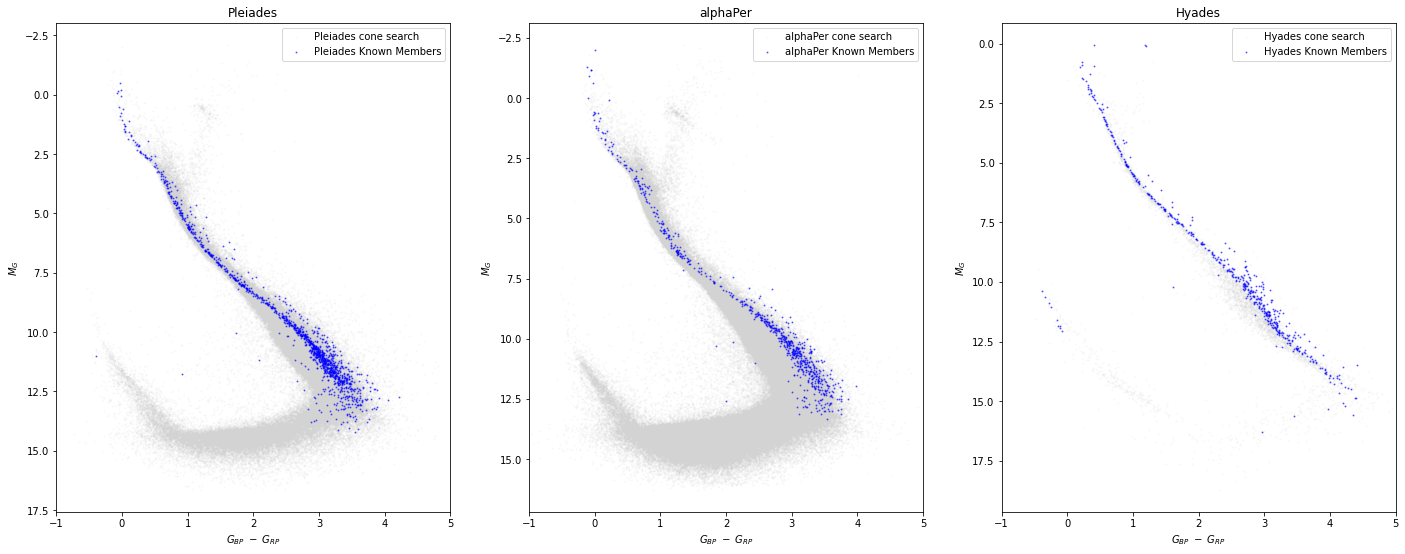

In [10]:
fig = plt.figure(figsize=(24,9))
ax = fig.subplots(1,3)
for i, cl in enumerate(cluster_names):
    search_results[cl].plot_hrdiagram(ax=ax[i], color='lightgrey', alpha=0.1, s=1, r_est=False)
    cluster_members[cl].plot_hrdiagram(ax=ax[i], color='blue', label=f'{cl} Known Members',alpha=0.5, s=1)
    ax[i].set_title(cl)
    ax[i].legend()


### Calculations
RA, Dec, PM_RA, PM_DEC calculated as unweighted mean of consitituents.

PM_RA_ERROR and PM_DEC_ERROR to be calculated as Root Means Square of the constituents' PM_RA_Error and PM_Dec_Error where:


$$
RMS(x) = \sqrt{\frac{1}{len(x)} * \sum x^2}
$$
See [Wikipedia](https://en.wikipedia.org/wiki/Root_mean_square)

## Initialize with Randomly Chosen Members

In [11]:
from src.perryman import perryman

In [12]:
n=20
pman_model={}
for cl in cluster_names:
    km = set(cluster_members[cl].objs.index)
    sr = set(search_results[cl].objs.index)
    common = [id for id in km.intersection(sr)]
    N = len(common)
    print(f'Cluster: {cl}: Number of common elements: {N}')
    els = np.random.choice(N, n, replace=False)
    elements = [common[el] for el in els]
    pman_model[cl]= perryman(search_results[cl].objs, init_members=elements)
    pman_model[cl].label_objs('TrueMember', pd.Series(True, index=cluster_members[cl].objs.index))




Cluster: Pleiades: Number of common elements: 1225
Model initialized with 20 members; Missing members: 0
Objects to be labeled: 1325, objects labeled: 1225, objects not found: 100
Cluster: alphaPer: Number of common elements: 699
Model initialized with 20 members; Missing members: 0
Objects to be labeled: 740, objects labeled: 699, objects not found: 41
Cluster: Hyades: Number of common elements: 401
Model initialized with 20 members; Missing members: 0
Objects to be labeled: 514, objects labeled: 401, objects not found: 113


In [13]:
fit_results = {}
for cl in cluster_names:
    print(f'Fitting cluster: {cl}')
    fit_results[cl] = pman_model[cl].fit(max_dist=20)

Fitting cluster: Pleiades
iterating
Iterations remaining: 94, number of members: 1364
Fitting cluster: alphaPer
iterating
Iterations remaining: 95, number of members: 850
Fitting cluster: Hyades
iterating
Iterations remaining: 93, number of members: 543


In [17]:
from plotting import plot_confusion_matrix

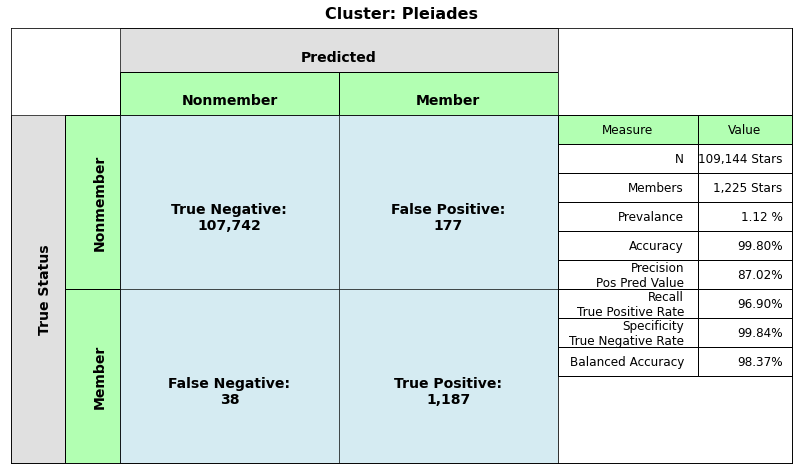

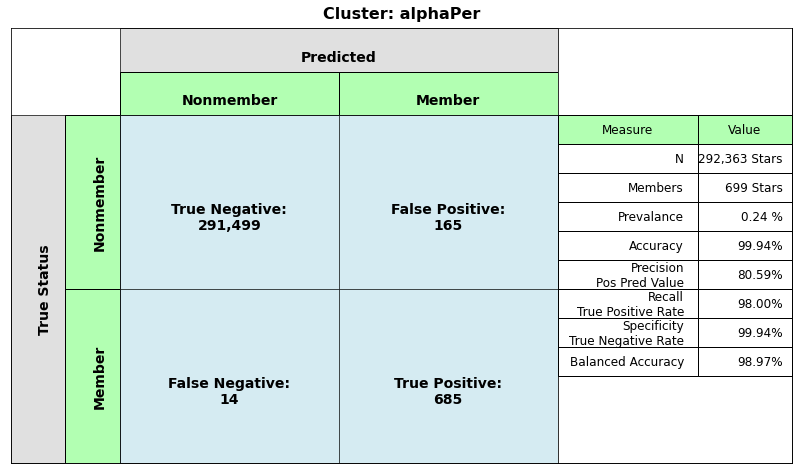

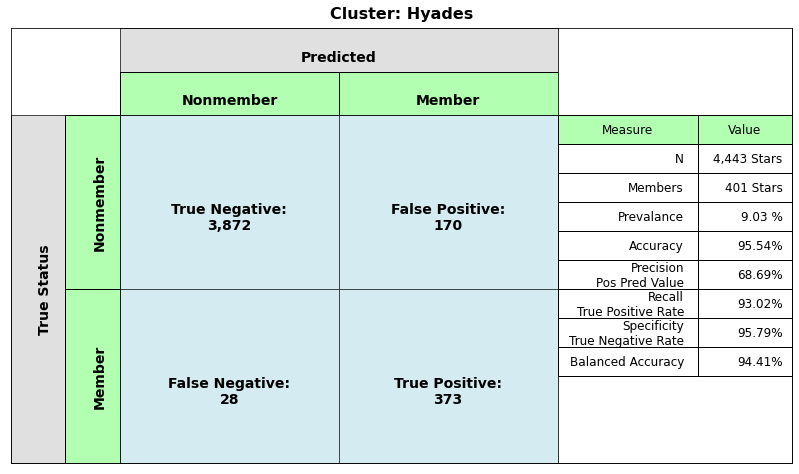

In [18]:
for cl in cluster_names:
    fig = plt.figure(figsize=(14,8))
    ax = fig.add_subplot()
    plot_confusion_matrix(pman_model[cl].objs.TrueMember, pman_model[cl].objs.IsMember, title=f'Cluster: {cl}',fig=fig, axl=ax)

In [19]:
pman_model['Hyades'].calculate_center_astrometrics()

{'ra': 67.8865399574291,
 'ra_error': 0.28831039201784275,
 'dec': 16.870322337586728,
 'dec_error': 0.2800080506851862,
 'parallax': 20.91599994831234,
 'parallax_error': 0.12746624001745843,
 'pmra': 96.56075053544369,
 'pmra_error': 1.0809342068049526,
 'pmdec': -28.161183459044306,
 'pmdec_error': 0.6688824986853042,
 'radial_velocity': 39.603848,
 'radial_velocity_error': 0.04084211366045928,
 'ra_dec_corr': -0.0659296044625852,
 'ra_parallax_corr': -0.2056133158506164,
 'ra_pmra_corr': -0.5219628865039886,
 'ra_pmdec_corr': -0.03511816575390512,
 'dec_parallax_corr': -0.09522805232638228,
 'dec_pmra_corr': 0.03951726501412684,
 'dec_pmdec_corr': -0.5478472926053616,
 'parallax_pmra_corr': 0.6794460898420911,
 'parallax_pmdec_corr': -0.1320750988324613,
 'pmra_pmdec_corr': -0.08433942499547835,
 'n_members': 543,
 'n_members_rv': 127}

## Initialize with Known Cluster Center

In [20]:
centers = {}
for cl in cluster_names:
    h_info=cluster_info.loc[cl]
    sqrt_n = np.sqrt(h_info['NMemb'])
    cen = {'ra':h_info['ra'], 'ra_error':np.nan,
                'dec':h_info['dec'], 'dec_error':np.nan,
                'parallax':h_info['plx'], 'parallax_error':h_info['e_plx']*sqrt_n,
                'pmra':h_info['pmra'], 'pmra_error':h_info['e_pmra']*sqrt_n,
                'pmdec':h_info['pmdec'], 'pmdec_error':h_info['e_pmdec']*sqrt_n,
                'radial_velocity':h_info['RV'], 'radial_velocity_error':h_info['e_RV']*sqrt_n}
    centers[cl]=pd.Series(cen)


In [21]:

pman_model2={}
for cl in cluster_names:

    pman_model2[cl]= perryman(search_results[cl].objs, init_members=centers[cl])
    pman_model2[cl].label_objs('TrueMember', pd.Series(True, index=cluster_members[cl].objs.index))

Model initialized with 0 members; Missing members: 0
Objects to be labeled: 1325, objects labeled: 1225, objects not found: 100
Model initialized with 0 members; Missing members: 0
Objects to be labeled: 740, objects labeled: 699, objects not found: 41
Model initialized with 0 members; Missing members: 0
Objects to be labeled: 514, objects labeled: 401, objects not found: 113


In [22]:
fit_results2 = {}
for cl in cluster_names:
    print(f'Fitting cluster: {cl}')
    fit_results2[cl] = pman_model2[cl].fit(max_dist=20)

Fitting cluster: Pleiades
iterating
Iterations remaining: 93, number of members: 1366
Fitting cluster: alphaPer
iterating
Iterations remaining: 95, number of members: 852
Fitting cluster: Hyades
iterating
Iterations remaining: 86, number of members: 494


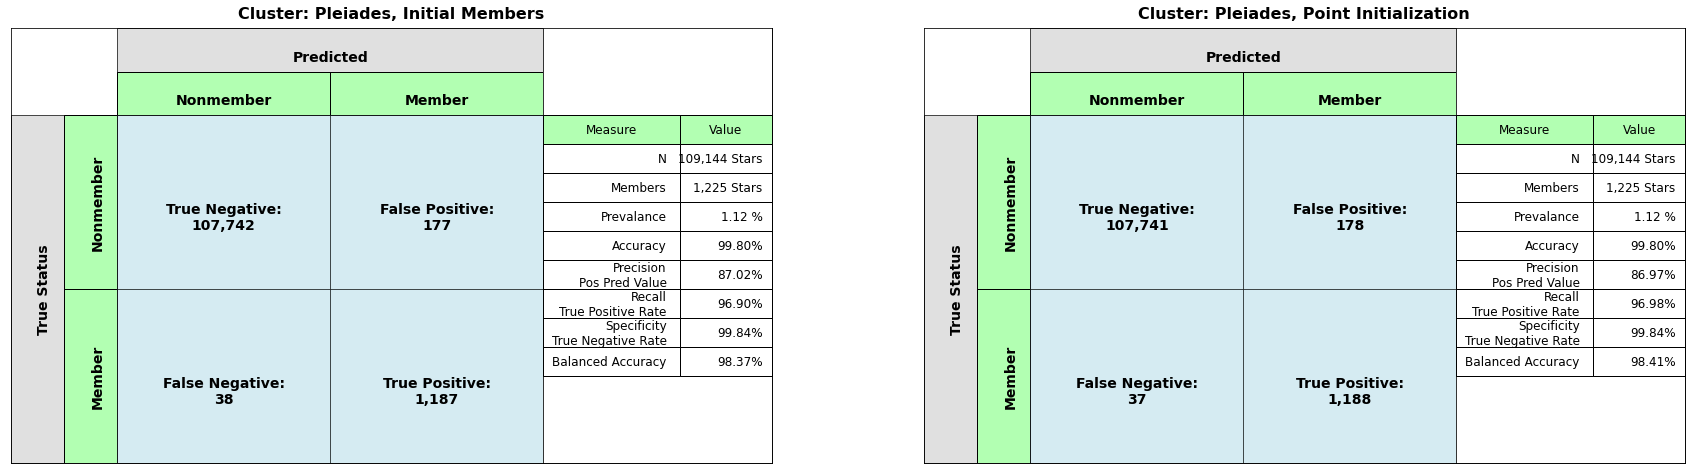

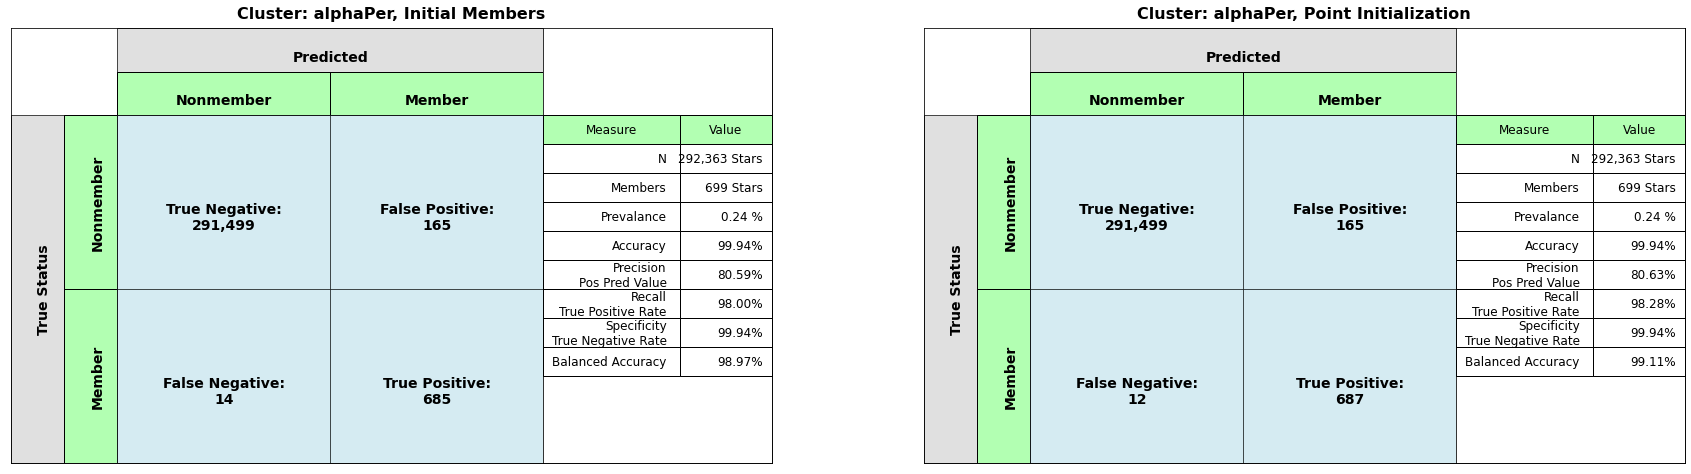

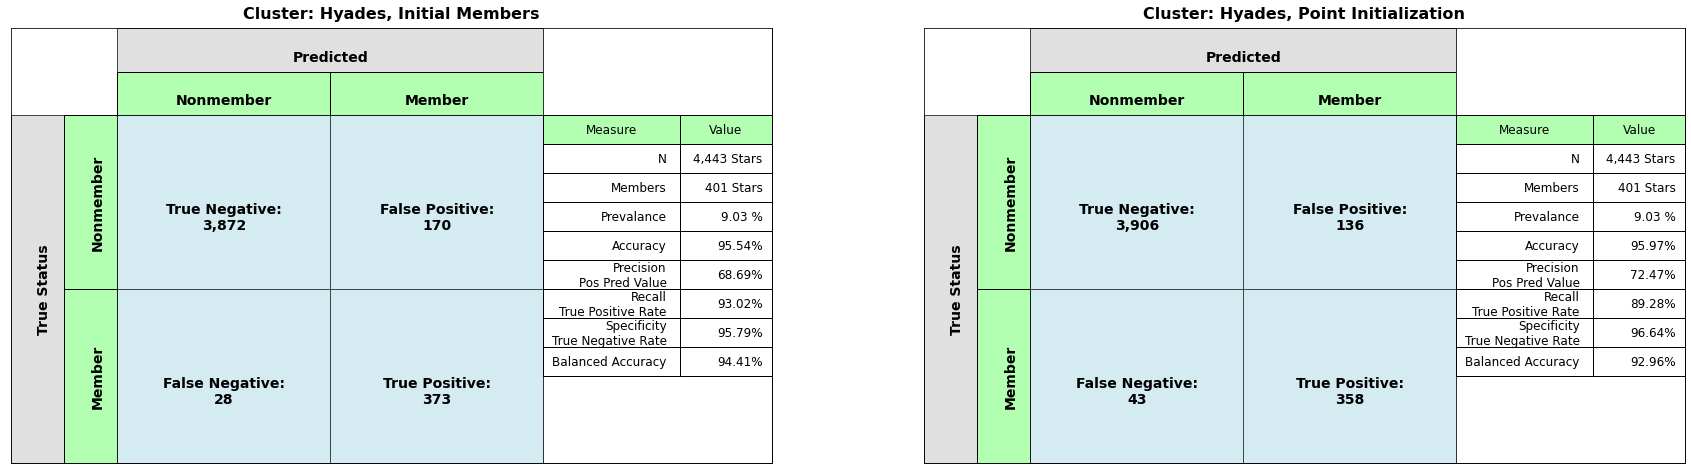

In [24]:
for cl in cluster_names:
    fig = plt.figure(figsize=(30,8))
    ax = fig.subplots(1,2)
    plot_confusion_matrix(pman_model[cl].objs.TrueMember, pman_model[cl].objs.IsMember, title=f'Cluster: {cl}, Initial Members',fig=fig, axl=ax[0])
    plot_confusion_matrix(pman_model2[cl].objs.TrueMember, pman_model2[cl].objs.IsMember, title=f'Cluster: {cl}, Point Initialization',fig=fig, axl=ax[1])



In [25]:

def plot_d_xyz(self, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (km/s)', 'Y Direction (km/s)', 'Z Direction (km/s)']

    for ax,i in zip(axs, cols):
        x = self.objs_d_xyz_2d[:, i[0],:].reshape(-1)
        y = self.objs_d_xyz_2d[:, i[1],:].reshape(-1)
        ax.scatter(x,y, s=1, label='Search Results', color='grey' )
        if show_rv:
            rv_stars = np.isfinite(self.objs.radial_velocity)
            stars_rv = np.logical_and(self.init_members, rv_stars)
            stars_norv = np.logical_and(self.init_members, ~rv_stars)
            ax.scatter(x[stars_norv], y[stars_norv], color='blue', s=1, label='Initial Members No RV' )
            ax.scatter(x[stars_rv], y[stars_rv], color='magenta', s=1, label='Initial Members RV' )

        else:
            ax.scatter(x[self.init_members], y[self.init_members], color='blue', s=1, label='Initial Members' )
        if hasattr(self,'members') and self.members is not None:
            ax.scatter(x[self.members], y[self.members], color='red', s=5, label='Final Members' )
        pm_x_percentile = np.percentile(self.objs_d_xyz_2d[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(self.objs_d_xyz_2d[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Space Velocity')


In [26]:
def plot_tang_v(self, fig, pm_percentile=(10,90), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['$V_{RA} (km/s)$', '$V_{Dec} (km/s)$', '$V_R (km/s)$']

    for ax,i in zip(axs, cols):
        x = self._tangental_velocity[:, i[0],:].reshape(-1)
        y = self._tangental_velocity[:, i[1],:].reshape(-1)
        ax.scatter(x,y, s=1, label='Search Results', color='lightgrey' )
        if show_rv:
            rv_stars = np.isfinite(self.objs.radial_velocity)
            stars_rv = np.logical_and(self.init_members, rv_stars)
            stars_norv = np.logical_and(self.init_members, ~rv_stars)
            ax.scatter(x[stars_norv], y[stars_norv], color='blue', s=5, label='Initial Members No RV' )
            ax.scatter(x[stars_rv], y[stars_rv], color='magenta', s=5, label='Initial Members RV' )
        else:
            ax.scatter(x[self.init_members], y[self.init_members], color='blue', s=5, label='Initial Members' )
        if hasattr(self,'members') and self.members is not None:
            ax.scatter(x[self.members], y[self.members], color='red', s=5, label='Final Members' )
        pm_x_percentile = np.percentile(self.objs_dxyz[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(self.objs_dxyz[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('Tangental and Radial Velocities')

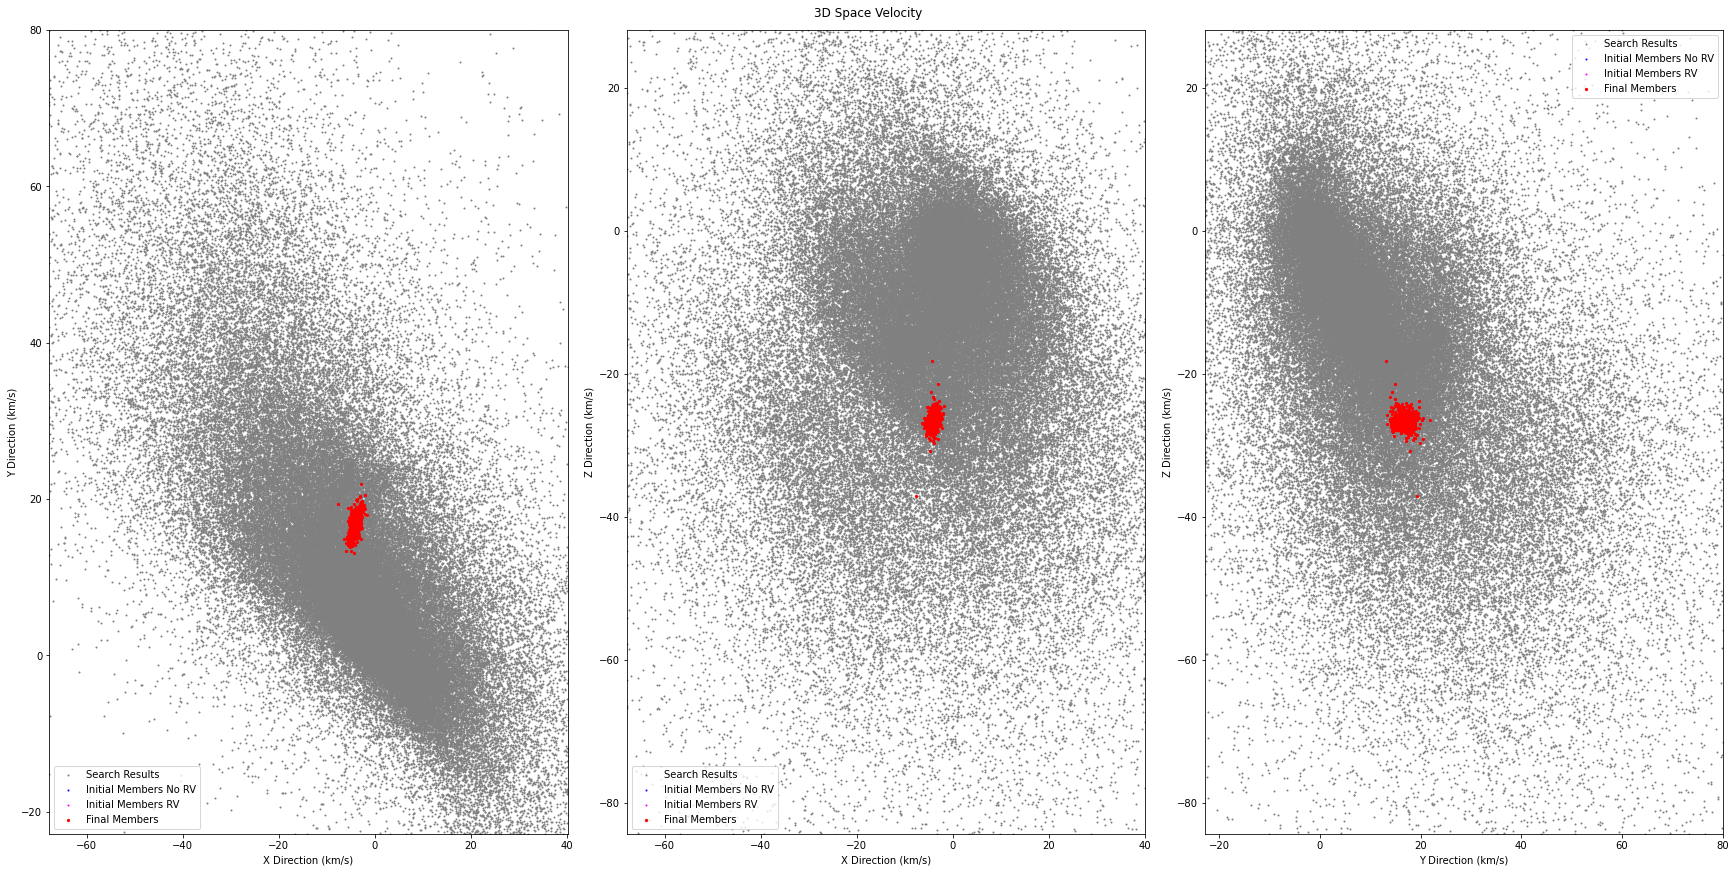

/home/kevin_leo_mcmanus/anaconda3/envs/astroml/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


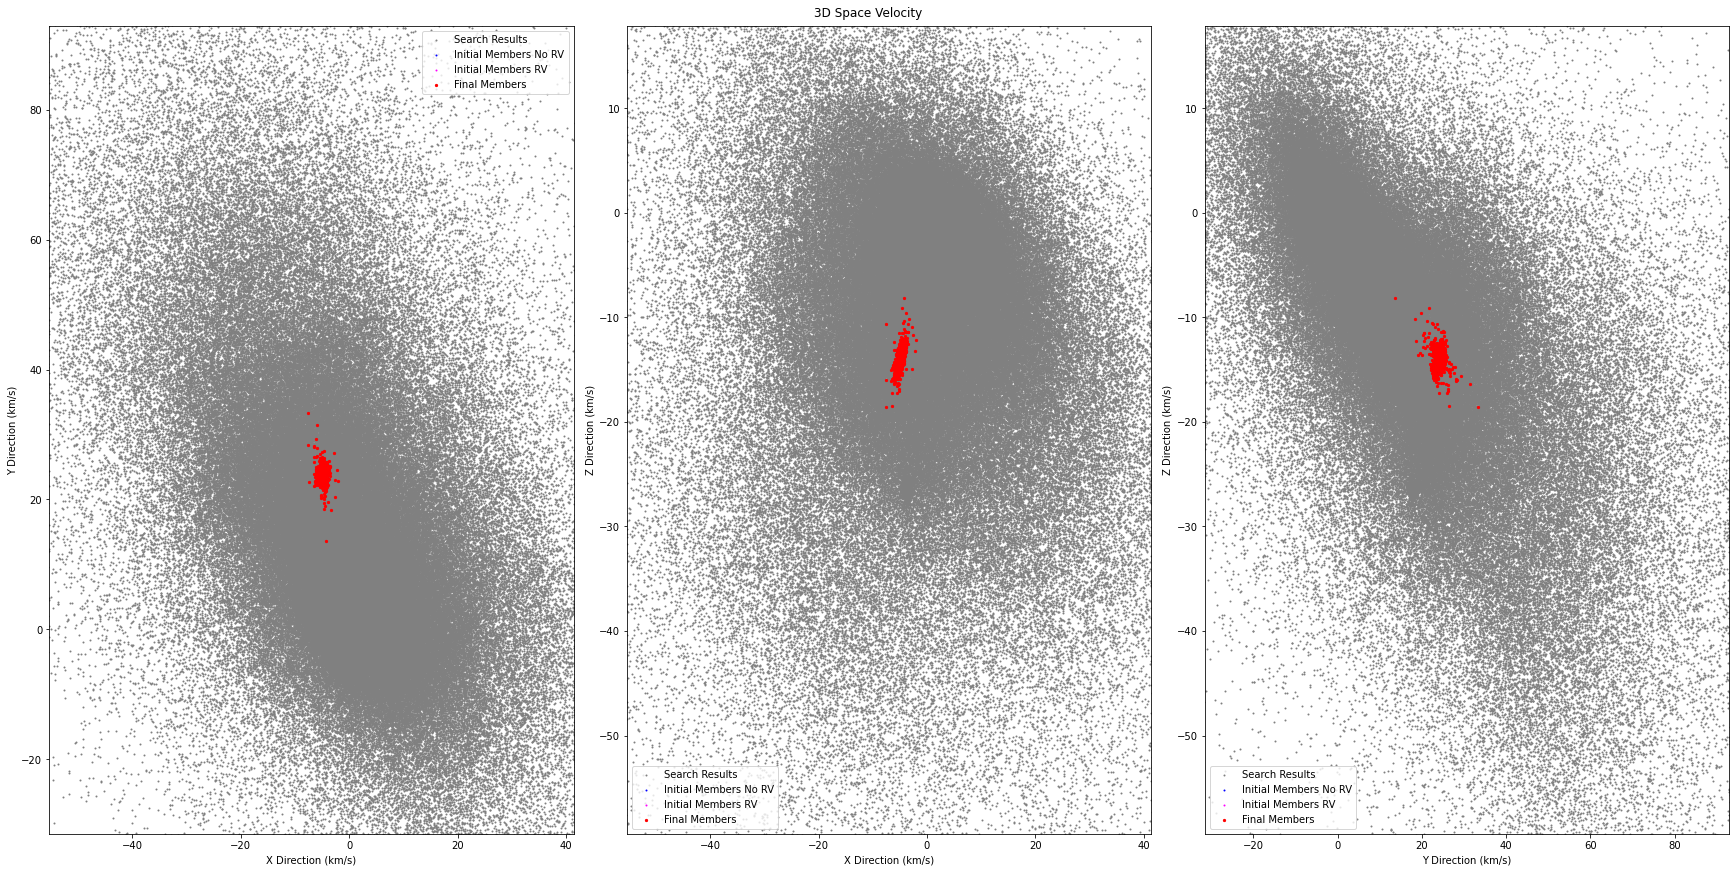

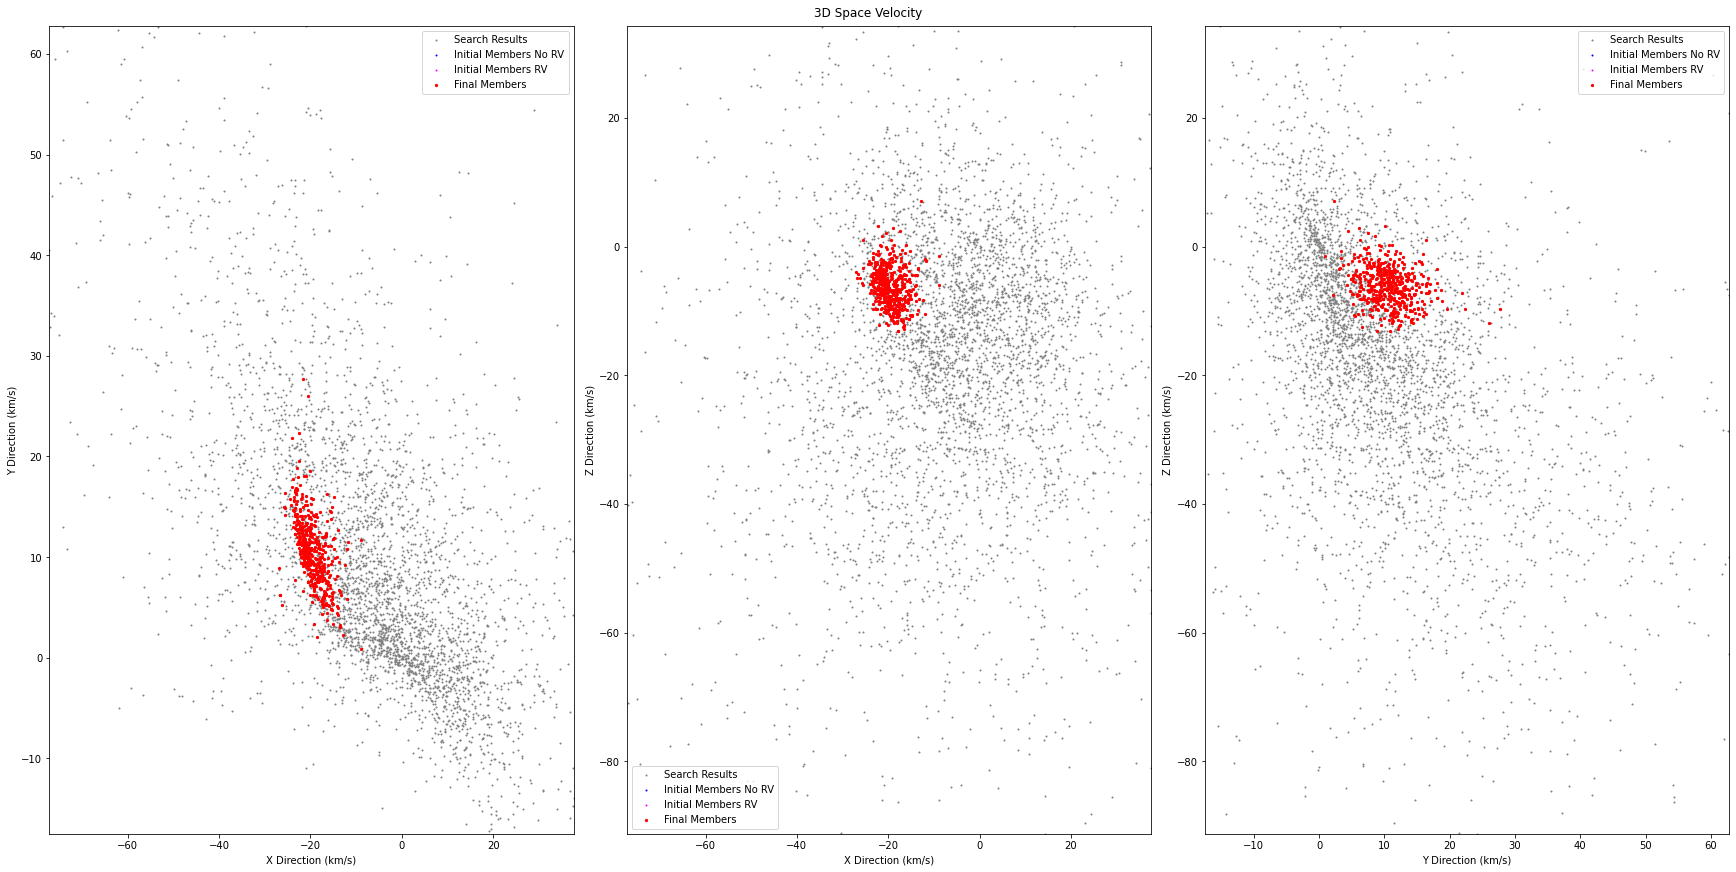

In [27]:
for cl in cluster_names:
    fig = plt.figure(figsize=(24,12), constrained_layout=True)
    plot_d_xyz(pman_model2[cl], fig, pm_percentile=(1,99))

In [23]:
def plot_xyz(plist, fig, pm_percentile=(0,100), show_rv=True):
    gs = fig.add_gridspec(1,3, width_ratios = [5,5,5])
    xyax = fig.add_subplot(gs[0])
    xzax = fig.add_subplot(gs[1])
    yzax = fig.add_subplot(gs[2])
    axs = [xyax, xzax, yzax]
    cols = [(0,1), (0,2), (1,2)]
    labs = ['X Direction (pc)', 'Y Direction (pc)', 'Z Direction (pc)']

    for ax,i in zip(axs, cols):
        x0 = plist[0].objs_xyz[:, i[0],:].reshape(-1)
        y0 = plist[0].objs_xyz[:, i[1],:].reshape(-1)
        x1 = plist[1].objs_xyz[:, i[0],:].reshape(-1)
        y1 = plist[1].objs_xyz[:, i[1],:].reshape(-1)
        ax.scatter(x0,y0, s=1, label='Search Results', color='lightgrey' )
        if hasattr(plist[0],'members') and plist[0].members is not None:
            ax.scatter(x0[plist[0].members], y0[plist[0].members], color='red', s=1, label='Final Members' )
        if hasattr(plist[1],'members') and plist[1].members is not None:
            ax.scatter(x1[plist[1].members], y1[plist[1].members], color='blue', s=1, label='Final Members' )

        pm_x_percentile = np.percentile(plist[0].objs_xyz[:, i[0],:].reshape(-1), pm_percentile)
        pm_y_percentile = np.percentile(plist[0].objs_xyz[:, i[1],:].reshape(-1), pm_percentile)
        ax.set_xlim(pm_x_percentile)
        ax.set_ylim(pm_y_percentile)
        ax.set_xlabel(labs[i[0]])
        ax.set_ylabel(labs[i[1]])
        ax.legend()


    fig.suptitle('3D Position')

In [24]:
from sklearn.linear_model import LinearRegression
import matplotlib.gridspec as gridspec

def est_velocity(self, fig=None, axl=None, pcttile=(5.0,95.0)):

    #get the stars with RV
    rv_stars = np.isfinite(self.objs.radial_velocity)
    d_xyz_2d = np.array([s.d_xyz_2d for s in self.stars if s.dof == 3]).reshape(-1,3)
    d_xyz_3d = np.array([s.d_xyz_3d for s in self.stars if s.dof == 3]).reshape(-1,3)

    #ditch the outliers

    v_2d = np.sqrt((d_xyz_2d**2).sum(axis=1))
    v_bounds = np.percentile(v_2d, pcttile)
    in_bounds = np.logical_and(v_2d >= v_bounds[0], v_2d <= v_bounds[1])
    v_2d = v_2d[in_bounds].reshape(-1,1)
    v_3d = np.sqrt((d_xyz_3d**2).sum(axis=1))[in_bounds].reshape(-1,1)

    lrmod = LinearRegression().fit(v_2d, v_3d)

    score = lrmod.score(v_2d.reshape(-1,1), v_3d)

    coefs = {'intercept':lrmod.intercept_, 'coef': lrmod.coef_, 'rsquared':score}

    if fig is not None:
        gspec = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=axl, width_ratios=[6.5,3.5],wspace=0.0)
        ax = fig.add_subplot(gspec[0])
        tblax = fig.add_subplot(gspec[1])

        v_2d_f = np.linspace(v_2d.min(), v_2d.max(), 10000)
        v_3d_f = lrmod.predict(v_2d_f.reshape(-1,1)).reshape(-1)

        ax.scatter(v_2d, v_3d, s=1, color='blue', label='Actual')
        ax.plot(v_2d_f, v_3d_f, color='red', lw=3, label='Fitted')
        #ax.plot(v_2d_f, v_2d_f, color='red',ls='-', lw=2, label='Abs(rv)=0')

        ax.set_xlabel('Velocity Assuming RV=0 (km/s')
        ax.set_ylabel('Velocity including RV (km/s)')

        ax.legend(loc='upper left')
        ax.grid()

            #plot the summary table to the right
        cspec = (0.0, 1.0, 0.0, 0.3)
        tbl2 = tblax.table(
            colLabels = ['Measure', 'Value'],
            colColours = [cspec, cspec], alpha=0.3,
            cellText = [
                ['Stars in Fit', f'{len(v_2d):,}'],
                ['R-Squared',f'{score:.4f}'],
                ['Intercept',f'{lrmod.intercept_[0]:.2f}'],
                ['Slope', f'{lrmod.coef_[0,0]:.2f}']
            ],
            colWidths=[0.6, 0.4],
            bbox=[0.0, 0.20, 1.0, 0.6])
        tbl2.auto_set_font_size(False)
        tbl2.set_fontsize(12)

        for a in [axl,  tblax]:
            a.xaxis.set_major_formatter(plt.NullFormatter())
            a.yaxis.set_major_formatter(plt.NullFormatter())
            a.set_yticks([])
            a.set_xticks([])

    return coefs

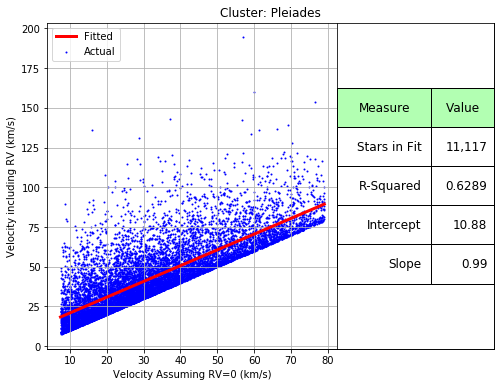

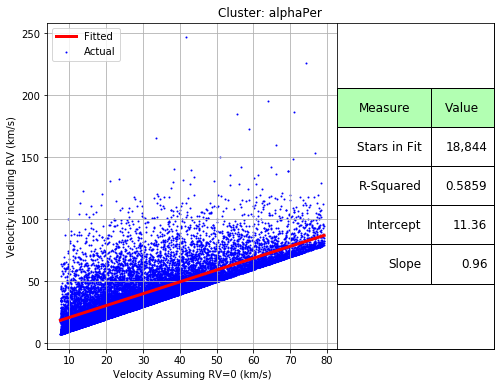

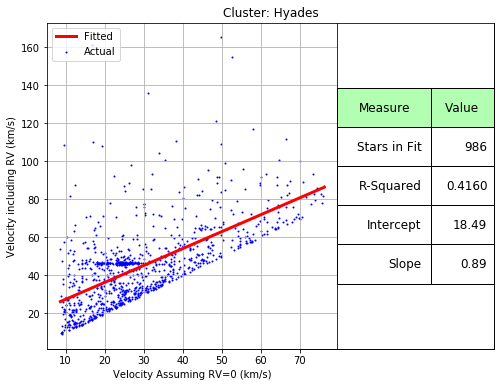

In [25]:
for cl in cluster_names:
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot()
    zz=pman_model2[cl].est_velocity( fig=fig, axl=ax)
    ax.set_title(f'Cluster: {cl}')


In [26]:
plt.NullFormatter

matplotlib.ticker.NullFormatter

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


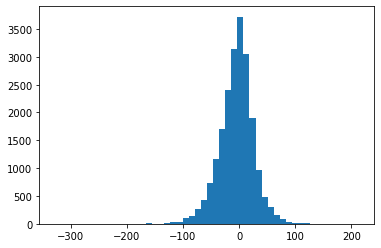

In [27]:
zz=plt.hist(pman_model2['alphaPer'].objs.radial_velocity,bins=50)

In [28]:
    def calculate_bc_velocity(self, cen_vel=None):

        sinalpha = np.sin(np.radians(self.objs.ra))
        cosalpha = np.cos(np.radians(self.objs.ra))
        sindelta = np.sin(np.radians(self.objs.dec))
        cosdelta = np.sin(np.radians(self.objs.dec))
        
        #get parameters by which to inflate velocities of stars w/o rv:
        coefs = self.est_velocity()

        #star's velocity assuming no rv
        d_xyz_2d = np.array([s.d_xyz_2d for s in self.stars]).reshape(-1,3)
        v_2d = np.sqrt((d_xyz_2d**2).sum(axis=1))
        #inflate it
        v_2d_rv = coefs['intercept'][0]+coefs['coef'][0,0]*v_2d
        delta_v_sq = v_2d_rv**2 - v_2d**2
        print(f'd_xyz_2d shape: {d_xyz_2d.shape}')
        print(f'v_2d shape: {v_2d.shape}')
        print(f'delta_v_sq shape: {delta_v_sq.shape}')
        rv_sq = delta_v_sq/((cosdelta*cosalpha)**2 + (cosdelta*sinalpha)**2 + sindelta**2)
        vel = rv_est = np.sqrt(rv_sq)

        
        return vel

In [29]:
perryman.est_velocity = est_velocity

In [30]:
rv_est = calculate_bc_velocity(pman_model2['Pleiades'])

d_xyz_2d shape: (109144, 3)
v_2d shape: (109144,)
delta_v_sq shape: (109144,)


In [31]:
rv_est[:10]

source_id
146386371078634752    21.957982
187144717365003776    18.321471
134166433207354496    40.068656
248678473300492160    35.437543
136415862197946880    36.171904
154367760343689216    21.789811
116788617571230720    27.135728
80919902571543424     62.082325
246153891521148288    14.214024
32454907488078208     67.854987
dtype: float64

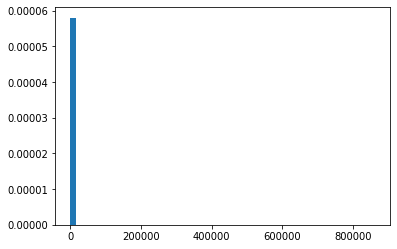

In [32]:
#zz=plt.hist(pman_model2['Pleiades'].objs.radial_velocity, bins=50, density=True)
zz=plt.hist(rv_est, bins=50, density=True)

In [33]:
rv_est.min()

10.444202044442127

In [34]:
(rv_est > 1000).sum()

1484

In [35]:
pman_model2['Pleiades'].stars[0].tang_v

array([[-0.91071374],
       [-0.24716666]])

In [36]:
tang_v = np.array([s.tang_v for s in pman_model2['Pleiades'].stars if s.dof==3] ).reshape(-1,3)
space_v = np.array([s.d_xyz_3d for s in pman_model2['Pleiades'].stars if s.dof==3]).reshape(-1,3)
tang_mag = (tang_v**2).sum(axis=1)
space_mag = (space_v**2).sum(axis=1)
np.allclose(tang_mag, space_mag)

True

In [37]:
tang_mag[:10]

array([3188.52018939, 1094.02043394,  176.40633877, 1592.63918474,
       1277.27739657, 3546.95026176,  510.07230621, 1718.13605002,
       3376.91839571,  211.42679765])

In [38]:
space_mag[:10]

array([3188.52018939, 1094.02043394,  176.40633877, 1592.63918474,
       1277.27739657, 3546.95026176,  510.07230621, 1718.13605002,
       3376.91839571,  211.42679765])

In [39]:

    def calculate_center_astrometrics(self):

        # get the means of the members:
        sqrt_n = np.sqrt(self.members.sum())
        member_means = self.objs[self.members].mean()
        # errors and correlations:
        cols = ['ra','dec','parallax', 'pmra', 'pmdec']
        err = self.objs[self.members][cols].std(ddof=1)
        corr = pd.DataFrame(np.corrcoef(self.objs[self.members][cols], rowvar=False),
                index=cols, columns=cols)

        #deal with radial velocity
        rv_members = np.logical_and(np.isfinite(self.objs.radial_velocity), self.members)
        n_rv = rv_members.sum()
        if n_rv > 0:
            sqrt_n_rv = np.sqrt(n_rv)
            rv = self.objs.radial_velocity[rv_members].mean()
            rv_error = self.objs.radial_velocity_error[rv_members].std(ddof=1)
        else:
            rv = rv_error = sqrt_n_rv = np.nan

        return {'ra': member_means.ra, 'ra_error':err.ra/sqrt_n,
             'dec': member_means.dec, 'dec_error':err.dec/sqrt_n,
             'parallax': member_means.parallax, 'parallax_error': err.parallax/sqrt_n,
             'pmra': member_means.pmra, 'pmra_error': err.pmra/sqrt_n,
             'pmdec': member_means.pmdec, 'pmdec_error': err.pmdec/sqrt_n,
             'radial_velocity': rv, 'radial_velocity_error': rv_error/sqrt_n_rv,
             'ra_dec_corr':        corr.loc['ra'].loc['dec'],
             'ra_parallax_corr':   corr.loc['ra'].loc['parallax'],
             'ra_pmra_corr':       corr.loc['ra'].loc['pmra'],
             'ra_pmdec_corr':      corr.loc['ra'].loc['pmdec'],
             'dec_parallax_corr':  corr.loc['dec'].loc['parallax'],
             'dec_pmra_corr':      corr.loc['dec'].loc['pmra'],
             'dec_pmdec_corr':     corr.loc['dec'].loc['pmdec'],
             'parallax_pmra_corr': corr.loc['parallax'].loc['pmra'],
             'parallax_pmdec_corr':corr.loc['parallax'].loc['pmdec'],
             'pmra_pmdec_corr':    corr.loc['pmra'].loc['pmdec'],
             'n_members': self.members.sum(),
             'n_members_rv': n_rv
              }

In [40]:
calculate_center_astrometrics(pman_model2['Hyades'])

{'ra': 67.74485790399251,
 'ra_error': 0.27541567482136564,
 'dec': 17.111689212951095,
 'dec_error': 0.28371764134618527,
 'parallax': 20.833379591023586,
 'parallax_error': 0.12790262348246154,
 'pmra': 98.37867408983746,
 'pmra_error': 1.041038762151811,
 'pmdec': -28.450176187551463,
 'pmdec_error': 0.6732890083838516,
 'radial_velocity': 39.47442626953125,
 'radial_velocity_error': 0.0405105162347729,
 'ra_dec_corr': -0.07225504210111067,
 'ra_parallax_corr': -0.18706974461784776,
 'ra_pmra_corr': -0.5568290933607786,
 'ra_pmdec_corr': -0.03418571664191427,
 'dec_parallax_corr': -0.12908510063961645,
 'dec_pmra_corr': -0.013066231807886073,
 'dec_pmdec_corr': -0.5918486593101315,
 'parallax_pmra_corr': 0.7439642221222384,
 'parallax_pmdec_corr': -0.16608621677427332,
 'pmra_pmdec_corr': -0.10591505834629843,
 'n_members': 494,
 'n_members_rv': 127}

In [41]:
cluster_info.loc['Hyades']

cluster,ra,dec,U,e_U,V,e_V,W,e_W,cUV,cUW,cVW,ra_conv,dec_conv,plx,e_plx,pmra,e_pmra,pmdec,e_pmdec,NMemb,uwsd,RV,e_RV,coords,DM,log_age,Fe_H,e_b_minus_v,NMembers,Z
,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg,pc",,,,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,object,float64,float64,float64,float64,int64,float64
Hyades,67.98,17.01,-6.059,0.031,45.691,0.069,5.544,0.025,0.33,0.35,0.93,97.5407,6.8148,21.052,0.065,101.005,0.171,-28.49,0.13699999999999998,515,0.67,39.96,0.06,"67.98,17.01,47.501425042751286",3.389,8.9,0.13,0.001,480,0.02


In [42]:
cluster_members['Hyades'].members=np.ones(len(cluster_members['Hyades'].objs), dtype=bool)

In [43]:
calculate_center_astrometrics(cluster_members['Hyades'])

{'ra': 67.68535204877442,
 'ra_error': 0.24241223174244336,
 'dec': 16.84071479575637,
 'dec_error': 0.2276680897035552,
 'parallax': 21.21000099328782,
 'parallax_error': 0.10779282827671882,
 'pmra': 102.83326188429619,
 'pmra_error': 1.0980829963322996,
 'pmdec': -27.058957136606203,
 'pmdec_error': 0.6931344291168289,
 'radial_velocity': 39.36392593383789,
 'radial_velocity_error': 0.04880963886606153,
 'ra_dec_corr': -0.18035263855075137,
 'ra_parallax_corr': -0.43509289348679964,
 'ra_pmra_corr': -0.8981758768180855,
 'ra_pmdec_corr': 0.0703096981796352,
 'dec_parallax_corr': -0.1423700395352048,
 'dec_pmra_corr': 0.04914211194365677,
 'dec_pmdec_corr': -0.9662395086633165,
 'parallax_pmra_corr': 0.7716592604053499,
 'parallax_pmdec_corr': 0.0389876156682646,
 'pmra_pmdec_corr': -0.020420312865344122,
 'n_members': 514,
 'n_members_rv': 156}